In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import math

In [2]:

train_x_slide = torch.load('./Downloads/train_x_slide.pt')
train_y_slide = torch.load('./Downloads/train_y_slide.pt')
train_y_gan = torch.load('./Downloads/train_y_gan.pt')
test_x_slide = torch.load('./Downloads/test_x_slide.pt')
test_y_slide = torch.load('./Downloads/test_y_slide.pt')
test_y_gan = torch.load('./Downloads/test_y_gan.pt')
validation_x_slide = torch.load('./Downloads/validation_x_slide.pt')
validation_y_slide = torch.load('./Downloads/validation_y_slide.pt')
validation_y_gan = torch.load('./Downloads/validation_y_gan.pt')


print(f'validation_x_slide: {validation_x_slide.shape}')
print(f'validation_y_slide: {validation_y_slide.shape}')
print(f'validation_y_gan: {validation_y_gan.shape}')
print(f'train_x_slide: {train_x_slide.shape}')
print(f'train_y_slide: {train_y_slide.shape}')
print(f'train_y_gan: {train_y_gan.shape}')
print(f'test_x_slide: {test_x_slide.shape}')
print(f'test_y_slide: {test_y_slide.shape}')
print(f'test_y_gan: {test_y_gan.shape}')

validation_x_slide: torch.Size([397, 3, 35])
validation_y_slide: torch.Size([397, 1])
validation_y_gan: torch.Size([397, 4, 1])
train_x_slide: torch.Size([1862, 3, 35])
train_y_slide: torch.Size([1862, 1])
train_y_gan: torch.Size([1862, 4, 1])
test_x_slide: torch.Size([397, 3, 35])
test_y_slide: torch.Size([397, 1])
test_y_gan: torch.Size([397, 4, 1])


#Generator and Discriminator



In [3]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm_1 = nn.LSTM(input_size, 1024, batch_first=True)
        self.lstm_2 = nn.LSTM(1024, 512, batch_first=True)
        self.lstm_3 = nn.LSTM(512, 256, batch_first=True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        c0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.lstm_1(x, (h0, c0))
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        c1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.lstm_2(out_1, (h1, c1))
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        c2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.lstm_3(out_2, (h2, c2))
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out



In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size = 3, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 3, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 3, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(128, 220)
        self.batch1 = nn.BatchNorm1d(220)
        self.linear2 = nn.Linear(220, 220)
        self.batch2 = nn.BatchNorm1d(220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        out = self.sigmoid(out_3)
        return out

##Training

In [5]:
class GAN(nn.Module):
    def __init__(self, generator, discriminator, device, learning_rate):
        super(GAN, self).__init__()
        self.generator = generator.to(device)
        self.discriminator = discriminator.to(device)
        self.device = device
        self.criterion = nn.BCELoss()
        self.optimizerG = torch.optim.Adam(self.generator.parameters(), lr=learning_rate, betas=(0.0, 0.9))
        self.optimizerD = torch.optim.Adam(self.discriminator.parameters(), lr=learning_rate, betas=(0.0, 0.9))

    def train(self, dataloader, num_epochs):
        histG = np.zeros(num_epochs)
        histD = np.zeros(num_epochs)

        for epoch in range(num_epochs):
            loss_G = []
            loss_D = []
            for x, y in dataloader:
                x, y = x.to(self.device), y.to(self.device)

                # Train discriminator on real data
                dis_real_output = self.discriminator(y)
                real_labels = torch.ones_like(dis_real_output, device=self.device)
                lossD_real = self.criterion(dis_real_output, real_labels)

                # Train discriminator on fake data
                fake_data = self.generator(x)
                # Assuming specific manipulation for fake data construction is necessary:
                fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis=1)
                dis_fake_output = self.discriminator(fake_data)
                fake_labels = torch.zeros_like(dis_fake_output, device=self.device)
                lossD_fake = self.criterion(dis_fake_output, fake_labels)

                # Discriminator loss
                lossD = lossD_real + lossD_fake
                self.optimizerD.zero_grad()
                lossD.backward(retain_graph=True)
                self.optimizerD.step()

                # Train generator
                output_fake = self.discriminator(fake_data)
                lossG = self.criterion(output_fake, real_labels)
                self.optimizerG.zero_grad()
                lossG.backward()
                self.optimizerG.step()

                loss_G.append(lossG.item())
                loss_D.append(lossD.item())

            histG[epoch] = np.mean(loss_G)
            histD[epoch] = np.mean(loss_D)
            print(f'[{epoch+1}/{num_epochs}] LossD: {np.mean(loss_D)} LossG: {np.mean(loss_G)}')

        return histG, histD

In [6]:
modelG = Generator(input_size=35)
modelD = Discriminator()
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
learning_rate = 0.00001
batch_size = 64
num_epochs = 200

gan_model = GAN(modelG, modelD, device, learning_rate)

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size, shuffle=False)
histG, histD = gan_model.train(trainDataloader, num_epochs)

[1/200] LossD: 1.3862499634424845 LossG: 0.6921576837698619
[2/200] LossD: 1.3862143357594807 LossG: 0.6928587555885315
[3/200] LossD: 1.3861892461776733 LossG: 0.6931170880794525
[4/200] LossD: 1.3861729184786478 LossG: 0.6931832472483317
[5/200] LossD: 1.3861681977907816 LossG: 0.6931930025418599
[6/200] LossD: 1.386182475090027 LossG: 0.6931916038195293
[7/200] LossD: 1.3862181941668192 LossG: 0.6931924859682719
[8/200] LossD: 1.386274222532908 LossG: 0.6931983689467113
[9/200] LossD: 1.3863401333491008 LossG: 0.6931941548983256
[10/200] LossD: 1.3864051183064778 LossG: 0.6931653241316478
[11/200] LossD: 1.386451284090678 LossG: 0.6931329548358918
[12/200] LossD: 1.3864731788635254 LossG: 0.6931172331174215
[13/200] LossD: 1.3864628434181214 LossG: 0.6931138396263122
[14/200] LossD: 1.3864168604214986 LossG: 0.69312957127889
[15/200] LossD: 1.3863368550936381 LossG: 0.6931730846563975
[16/200] LossD: 1.3862717827161153 LossG: 0.6931867162386577
[17/200] LossD: 1.3862440586090088 Los

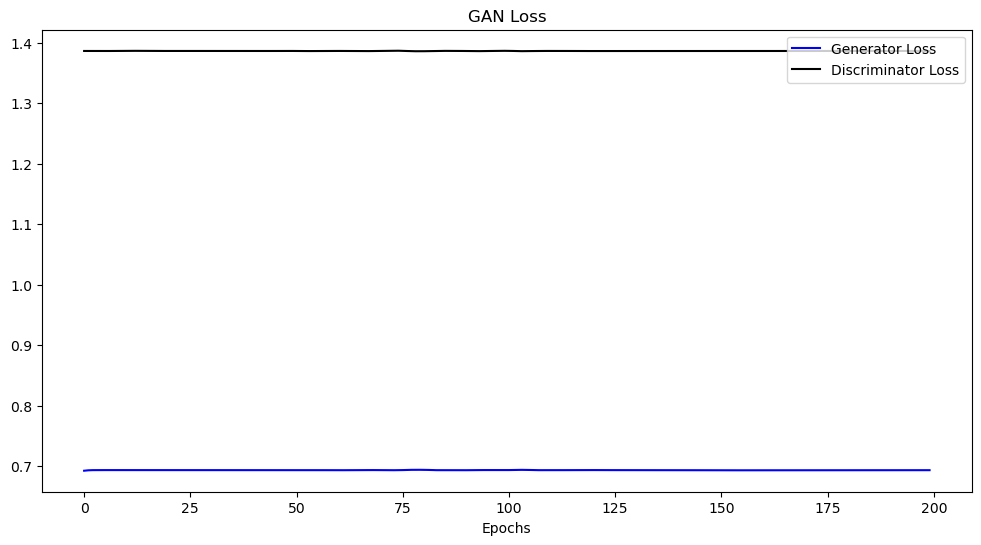

In [7]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Epochs')
plt.legend(loc = 'upper right')

In [8]:

modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train = train_y_slide
y_test = test_y_slide

In [9]:
import pickle

# Load the saved scaler
y_scaler = pickle.load(open('./Downloads/target_scaler.pkl', 'rb'))

# Use the loaded scaler to inverse transform the data
rescaled_y_train = y_scaler.inverse_transform(y_train)
rescaled_y_test = y_scaler.inverse_transform(y_test)


rescaled_pred_y_train = y_scaler.inverse_transform(pred_y_train.detach().numpy())
rescaled_pred_y_test = y_scaler.inverse_transform(pred_y_test.detach().numpy())

/opt/anaconda3/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Training dataset RMSE:1.6054039356354255


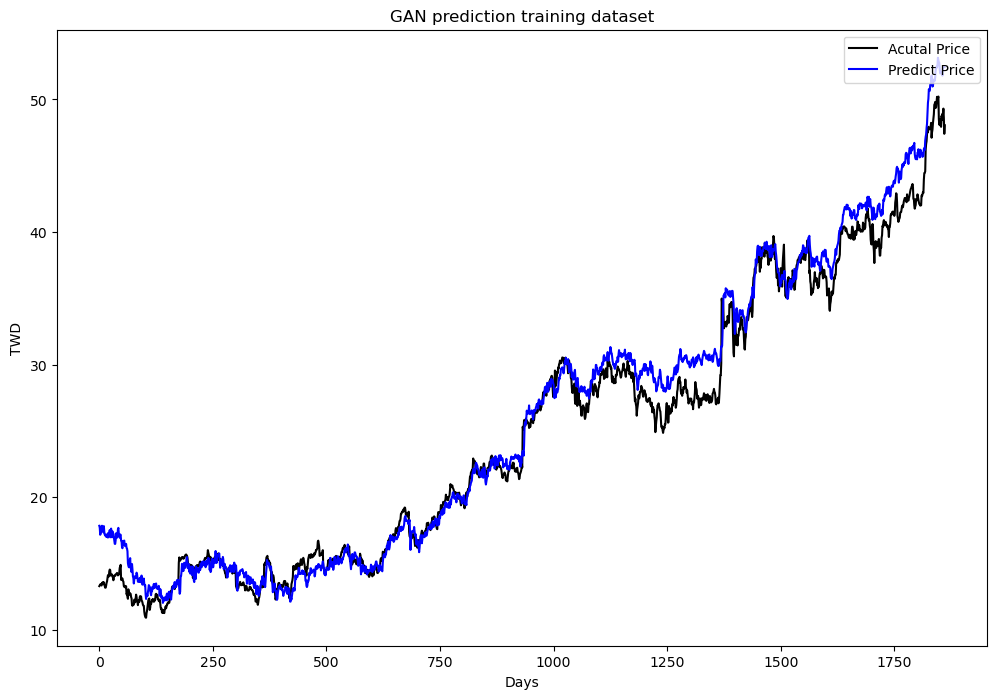

In [10]:

plt.figure(figsize=(12, 8))
plt.plot(rescaled_y_train, color = 'black', label = 'Acutal Price')
plt.plot(rescaled_pred_y_train, color = 'blue', label = 'Predict Price')

plt.title('GAN prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(rescaled_y_train, rescaled_pred_y_train)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:14.56315925816067


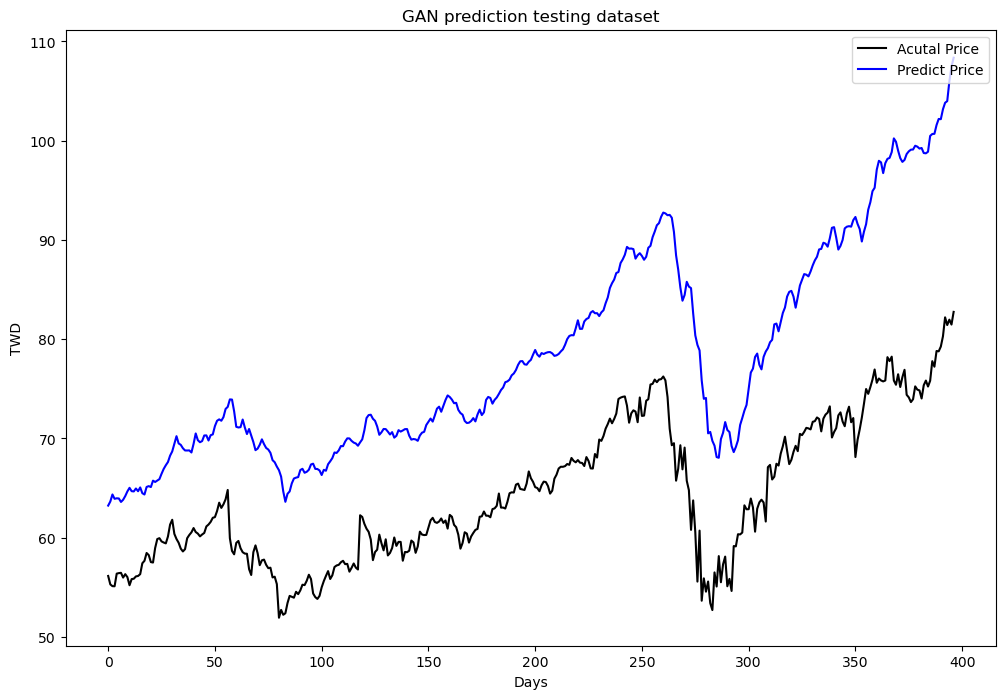

In [11]:

plt.figure(figsize=(12, 8))
plt.plot(rescaled_y_test, color = 'black', label = 'Acutal Price')
plt.plot(rescaled_pred_y_test, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(rescaled_y_test, rescaled_pred_y_test)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

##hyperparameter tuning

In [ ]:
batch_size_options = [64, 128, 256]
learning_rate_options = [0.001, 0.0001, 0.00001]
num_epochs_options = [100, 150, 200, 250, 300]



num_trials = 50  # Number of trials in the random search
best_rmse = float('inf')
best_params = {}

for trial in range(num_trials):
    batch_size = int(np.random.choice(batch_size_options))
    learning_rate = float(np.random.choice(learning_rate_options))
    num_epochs = int(np.random.choice(num_epochs_options))
    input_size = 35
    print(f'num trial: {trial}, batch_size: {batch_size}, learning_rate: {learning_rate}, num_epochs: {num_epochs}')


    modelG = Generator(input_size=35).to(device)
    modelD = Discriminator().to(device)

    # Initialize the GAN model with the randomly chosen hyperparameters
    gan_model = GAN(modelG, modelD, device, learning_rate)

    # Create a DataLoader with the chosen batch size
    trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size, shuffle=False)

    # Train the model and get the loss history
    histG, histD = gan_model.train(trainDataloader, num_epochs)
    plt.figure(figsize = (12, 6))
    plt.plot(histG, color = 'blue', label = 'Generator Loss')
    plt.plot(histD, color = 'black', label = 'Discriminator Loss')
    plt.title(f'GAN Loss - Trial #{trial}')
    plt.xlabel('Epochs')
    plt.legend(loc = 'upper right')

    modelG.eval()

    pred_y_validation = modelG(validation_x_slide.to(device))
    rescaled_y_validation = y_scaler.inverse_transform(validation_y_slide)
    rescaled_pred_y_validation = y_scaler.inverse_transform(pred_y_validation.detach().numpy())


    MSE_validation = mean_squared_error(rescaled_y_validation, rescaled_pred_y_validation)
    rmse = math.sqrt(MSE_validation)

    print(rmse)

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = {'batch_size': batch_size, 'learning_rate': learning_rate, 'num_epochs': num_epochs}

print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")

Output hidden; open in https://colab.research.google.com to view.

In [12]:
modelG = Generator(input_size=35)
modelD = Discriminator()
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
learning_rate = 0.00001
batch_size = 64
num_epochs = 200

gan_model = GAN(modelG, modelD, device, learning_rate)

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size, shuffle=False)
histG, histD = gan_model.train(trainDataloader, num_epochs)

[1/200] LossD: 1.3870937705039978 LossG: 0.7217278103033702
[2/200] LossD: 1.386851676305135 LossG: 0.7169586420059204
[3/200] LossD: 1.3866579174995421 LossG: 0.7122936507066091
[4/200] LossD: 1.3865096767743428 LossG: 0.7077127357323965
[5/200] LossD: 1.3864043911298116 LossG: 0.7033036847909292
[6/200] LossD: 1.3863396326700845 LossG: 0.699279765288035
[7/200] LossD: 1.386305848757426 LossG: 0.6959560513496399
[8/200] LossD: 1.3862891832987467 LossG: 0.6938723186651866
[9/200] LossD: 1.3862777868906657 LossG: 0.6932076672712962
[10/200] LossD: 1.386270034313202 LossG: 0.6931403756141663
[11/200] LossD: 1.3862666090329487 LossG: 0.6931315938631694
[12/200] LossD: 1.3862669070561726 LossG: 0.6931332170963287
[13/200] LossD: 1.38626895348231 LossG: 0.6931218902269999
[14/200] LossD: 1.386271603902181 LossG: 0.6931215325991312
[15/200] LossD: 1.3862725536028544 LossG: 0.693123592933019
[16/200] LossD: 1.3862702012062074 LossG: 0.6931259214878083
[17/200] LossD: 1.3862642288208007 LossG:

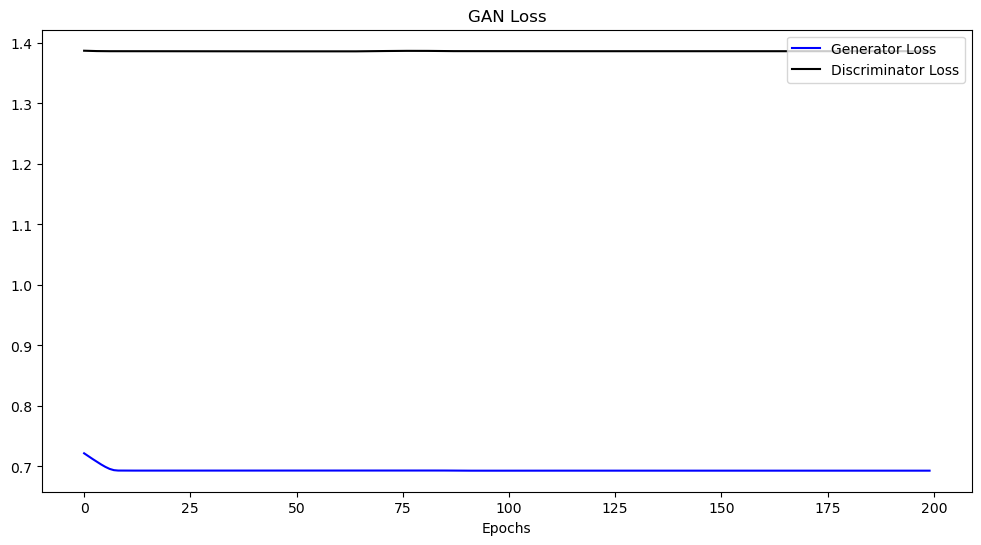

In [13]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Epochs')
plt.legend(loc = 'upper right')

In [14]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train = train_y_slide
y_test = test_y_slide

In [15]:
import pickle

# Load the saved scaler
y_scaler = pickle.load(open('./Downloads/target_scaler.pkl', 'rb'))

# Use the loaded scaler to inverse transform the data
rescaled_y_train = y_scaler.inverse_transform(y_train)
rescaled_y_test = y_scaler.inverse_transform(y_test)


rescaled_pred_y_train = y_scaler.inverse_transform(pred_y_train.detach().numpy())
rescaled_pred_y_test = y_scaler.inverse_transform(pred_y_test.detach().numpy())

/opt/anaconda3/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


train dataset RMSE:1.2447090319704308
Train dataset MAPE:0.04668635499380964
Train dataset MAE:0.9902804626625931


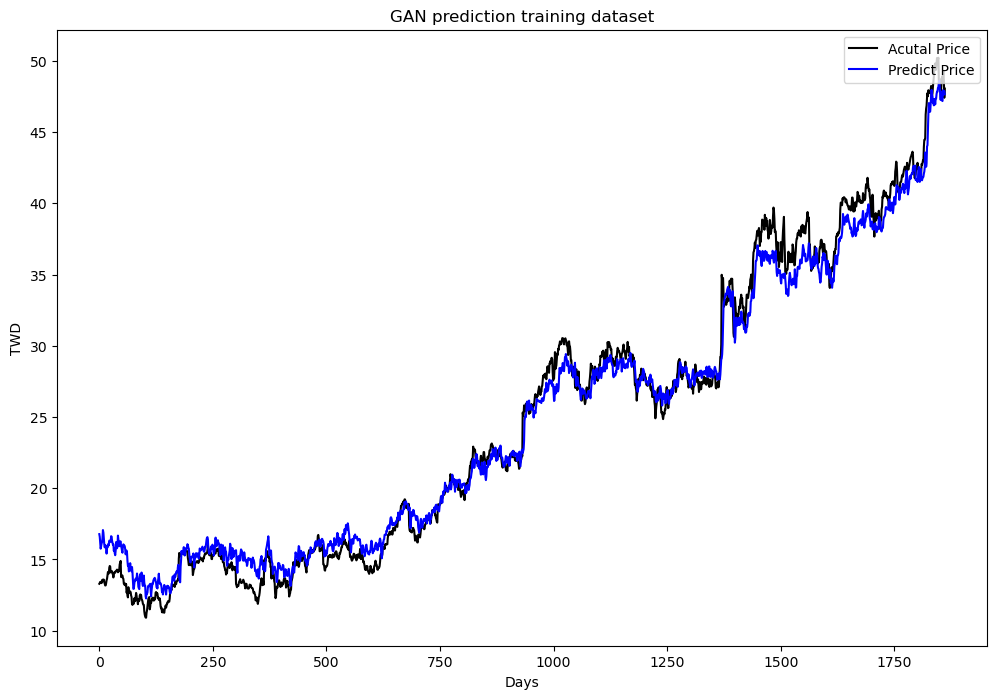

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(rescaled_y_train, color = 'black', label = 'Acutal Price')
plt.plot(rescaled_pred_y_train, color = 'blue', label = 'Predict Price')

plt.title('GAN prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(rescaled_y_train, rescaled_pred_y_train)
RMSE = math.sqrt(MSE)
MAPE = mean_absolute_percentage_error(rescaled_y_train, rescaled_pred_y_train)
MAE = mean_absolute_error(rescaled_y_train, rescaled_pred_y_train)
print(f'train dataset RMSE:{RMSE}')
print(f'Train dataset MAPE:{MAPE}')
print(f'Train dataset MAE:{MAE}')

Test dataset RMSE:4.974569845850679
Test dataset MAPE:0.06430527138610892
Test dataset MAE:4.14215811025546


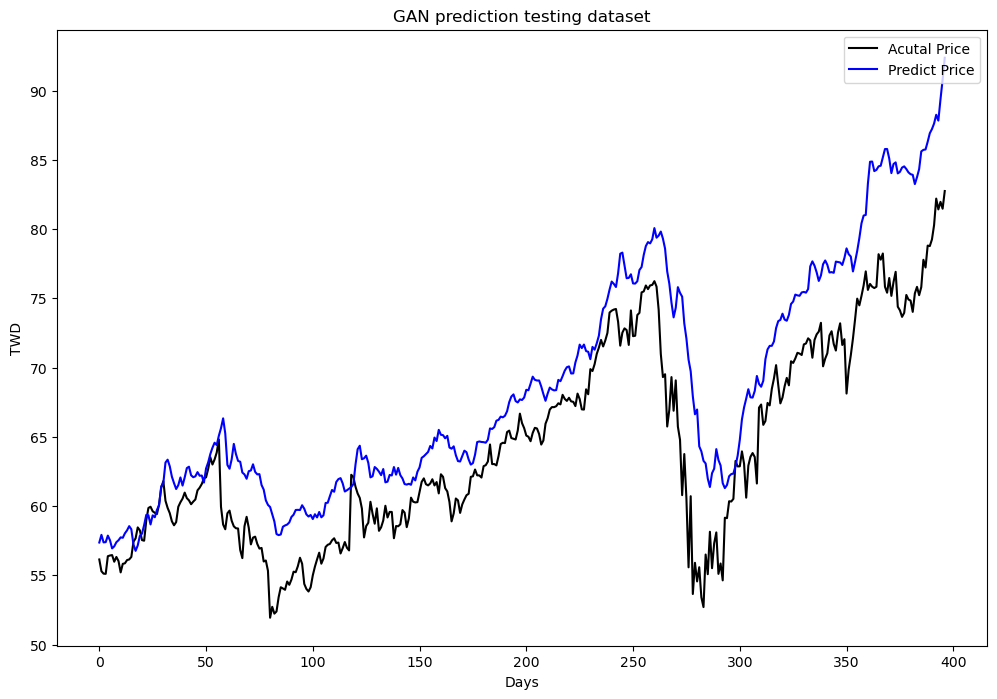

In [17]:

plt.figure(figsize=(12, 8))
plt.plot(rescaled_y_test, color = 'black', label = 'Acutal Price')
plt.plot(rescaled_pred_y_test, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(rescaled_y_test, rescaled_pred_y_test)
RMSE = math.sqrt(MSE)
MAPE = mean_absolute_percentage_error(rescaled_y_test, rescaled_pred_y_test)
MAE = mean_absolute_error(rescaled_y_test, rescaled_pred_y_test)
print(f'Test dataset RMSE:{RMSE}')
print(f'Test dataset MAPE:{MAPE}')
print(f'Test dataset MAE:{MAE}')

##subsampling

In [18]:
y_test = test_y_slide

subsample_rmses = []


# Iterate over the test set in windows of 50 days
for start in range(0, len(test_x_slide), 50):
    end = start + 50
    # If the last window has less than 50 days, we take whatever is remaining
    if end > len(test_x_slide):
        end = len(test_x_slide)

    # Slice the test set to get a subsample
    subsample_x = test_x_slide[start:end]
    subsample_y = y_test[start:end]

    # Make predictions on the subsample
    pred_y_subsample = modelG(subsample_x.to(device))

    # Use the loaded scaler to inverse transform the data

    rescaled_y_test = y_scaler.inverse_transform(subsample_y)

    rescaled_pred_y_test = y_scaler.inverse_transform(pred_y_subsample.detach().numpy())

    MSE = mean_squared_error(rescaled_y_test, rescaled_pred_y_test)
    RMSE = math.sqrt(MSE)
    subsample_rmses.append(RMSE)


print(f'Subsample RMSE: {subsample_rmses}')

Subsample RMSE: [1.7365315465953117, 4.747577689403174, 3.457799552720324, 2.746283636524285, 3.016484671703352, 7.540459633262047, 4.788495282872426, 8.157042337470617]


In [19]:
df = pd.DataFrame(subsample_rmses, columns=['RMSE'])


df.to_csv('./Downloads/GANsubsample_rmses.csv', index=False)

